In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Logistic Ridge Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(beta, X, y, lambda_):
    logits = X @ beta
    log_likelihood = -np.mean(y * logits - np.log(1 + np.exp(logits))) * X.shape[0]
    ridge_penalty = 0.5 * lambda_ * np.sum(beta**2)
    return log_likelihood + ridge_penalty

def gradient(beta, X, y, lambda_):
    p = sigmoid(X @ beta)
    return -X.T @ (y - p) + lambda_ * beta

def hessian(beta, X, lambda_):
    p = sigmoid(X @ beta)
    W = np.diag(p * (1 - p))
    return X.T @ W @ X + lambda_ * np.eye(X.shape[1])

def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100):
    beta = beta_init.copy()
    for step_count in range(1, max_iter + 1):
        grad = gradient(beta, X, y, lambda_)
        hess = hessian(beta, X, lambda_)
        step = np.linalg.solve(hess, grad)
        beta -= step
        if np.linalg.norm(step) < tol:
            return beta, step_count
    return beta, max_iter


# Set seed for reproducibility
np.random.seed(1)

# Parameters
n         = 500  # Fixed sample size
p         = 1000  # Fixed number of features
lambda_   = 0.01  # Regularization constant
beta_star = np.random.normal(0, 1, p)
X         = np.random.normal(0, 1 / np.sqrt(n), (n, p))
logits    = X @ beta_star
prob      = sigmoid(logits)
y         = np.random.binomial(1, prob)
beta_init = np.random.normal(0, 1, p) * 0.01
# Compute Newton steps for beta_hat
beta_hat, steps_used = newton_step(beta_init, X, y, lambda_)
# Compute hat matrix H
# Compute predicted probabilities and weights
p_hat = sigmoid(X @ beta_hat)
w = p_hat * (1 - p_hat)  # shape (n,)

# Weighted design matrix
WX = X * w[:, np.newaxis]  # element-wise multiply each row of X by w_i

# Compute Hessian and its inverse
hessian_matrix = X.T @ WX + lambda_ * np.eye(p)
hessian_inv = np.linalg.solve(hessian_matrix, np.eye(p))  # shape (p, p)

# Compute diagonal of the hat matrix: H_ii = w_i * x_i^T @ hessian_inv @ x_i
H_diag = np.einsum('ij,jk,ik->i', X, hessian_inv, X) * w  # shape (n,)

# Trace of H divided by number of features
tr_H = np.sum(H_diag) / p

print(f"Effective df (tr(H)/p) = {tr_H:.4f}, lambda = {lambda_}, n = {n}, p = {p}, Newton Steps: {steps_used}")


#W        = np.diag(p_hat * (1 - p_hat))
#H        = X @ hess_inv @ X.T @ W
#tr_H     = np.trace(H) / p
#print(tr_H)

Effective df (tr(H)/p) = 0.3450, lambda = 0.01, n = 500, p = 1000, Newton Steps: 8


In [70]:
m = 100  # number of unseen test points

# Sample m new test points
X_new      = np.random.normal(0, 1 / np.sqrt(n), size=(m, p))
logits_new = X_new @ beta_star
probs_new  = sigmoid(logits_new)
y_new      = np.random.binomial(1, probs_new)

# Precompute full model predictions for all test points
logits_full = X_new @ beta_hat
loss_full   = -y_new * logits_full + np.log(1 + np.exp(logits_full))  # shape (m,)

# Preallocate arrays (n training points × m test points)
loss_changes        = np.zeros((n, m))
approx_loss_changes = np.zeros((n, m))
influence_values    = np.zeros((n, m))

# Compute full-data gradient and Hessian once
eta = X @ beta_hat
p_hat = sigmoid(eta)
w = p_hat * (1 - p_hat)
WX = X * w[:, np.newaxis]
hessian_matrix = X.T @ WX + lambda_ * np.eye(p)
hessian_matrix_inv = np.linalg.solve(hessian_matrix, np.eye(p))  # shared for all i

# Loop over training points
for i in range(n):
    # Leave-one-out retraining
    X_minus_i = np.delete(X, i, axis=0)
    y_minus_i = np.delete(y, i)

    beta_init_minus_i = np.random.normal(0, 1, p) * 0.01
    beta_hat_minus_i, steps = newton_step(beta_init_minus_i, X_minus_i, y_minus_i, lambda_)

    # True LOO loss on all test points
    logits_minus_i = X_new @ beta_hat_minus_i
    loss_minus_i = -y_new * logits_minus_i + np.log(1 + np.exp(logits_minus_i))  # shape (m,)
    loss_changes[i, :] = loss_minus_i - loss_full

    # First-order approx beta_{/i}
    w_minus_i = np.delete(w, i)
    WX_i = X_minus_i * w_minus_i[:, np.newaxis]
    hessian_i = X_minus_i.T @ WX_i + lambda_ * np.eye(p)
    hessian_i_inv = np.linalg.solve(hessian_i, np.eye(p))

    # First derivative of logistic loss at point i
    p_i = p_hat[i]
    y_i = y[i]
    x_i = X[i]
    grad_i = (p_i - y_i) * x_i

    # First order correction
    beta_tilde_i = beta_hat + hessian_i_inv @ grad_i

    # Loss with approx beta on test points
    logits_tilde_i = X_new @ beta_tilde_i
    loss_tilde_i = -y_new * logits_tilde_i + np.log(1 + np.exp(logits_tilde_i))
    approx_loss_changes[i, :] = loss_tilde_i - loss_full

    # Influence estimates on test loss
    for j in range(m):
        p_new = probs_new[j]
        grad_test = (p_new - y_new[j]) * X_new[j]
        beta_influence_i = beta_hat + hessian_matrix_inv @ grad_i
        logit_influence_i = X_new[j] @ beta_influence_i
        loss_influence_i = -y_new[j] * logit_influence_i + np.log(1 + np.exp(logit_influence_i))
        influence_values[i, j] = loss_influence_i - loss_full[j]
        #influence_values[i, j] = grad_test @ hessian_matrix_inv @ grad_i

    # Optionally print summary stats per training point
    print(f"Point {i:4d}: ΔLoss = {loss_changes[i,1]:7.4f},  ΔLoss_tilde = {approx_loss_changes[i,1]:7.4f}, Influence = {influence_values[i,1]:9.5f}, Steps = {steps:2d}")


Point    0: ΔLoss = -0.0028,  ΔLoss_tilde = -0.0028, Influence =  -0.00267, Steps =  3
Point    1: ΔLoss = -0.0003,  ΔLoss_tilde = -0.0003, Influence =  -0.00032, Steps =  3
Point    2: ΔLoss =  0.0013,  ΔLoss_tilde =  0.0013, Influence =   0.00120, Steps =  3
Point    3: ΔLoss =  0.0009,  ΔLoss_tilde =  0.0009, Influence =   0.00084, Steps =  3
Point    4: ΔLoss = -0.0020,  ΔLoss_tilde = -0.0020, Influence =  -0.00196, Steps =  3
Point    5: ΔLoss = -0.0020,  ΔLoss_tilde = -0.0020, Influence =  -0.00188, Steps =  3
Point    6: ΔLoss =  0.0018,  ΔLoss_tilde =  0.0018, Influence =   0.00169, Steps =  3
Point    7: ΔLoss = -0.0040,  ΔLoss_tilde = -0.0040, Influence =  -0.00384, Steps =  3
Point    8: ΔLoss = -0.0025,  ΔLoss_tilde = -0.0025, Influence =  -0.00242, Steps =  3
Point    9: ΔLoss =  0.0001,  ΔLoss_tilde =  0.0001, Influence =   0.00010, Steps =  3
Point   10: ΔLoss =  0.0028,  ΔLoss_tilde =  0.0028, Influence =   0.00268, Steps =  3
Point   11: ΔLoss = -0.0018,  ΔLoss_tilde =

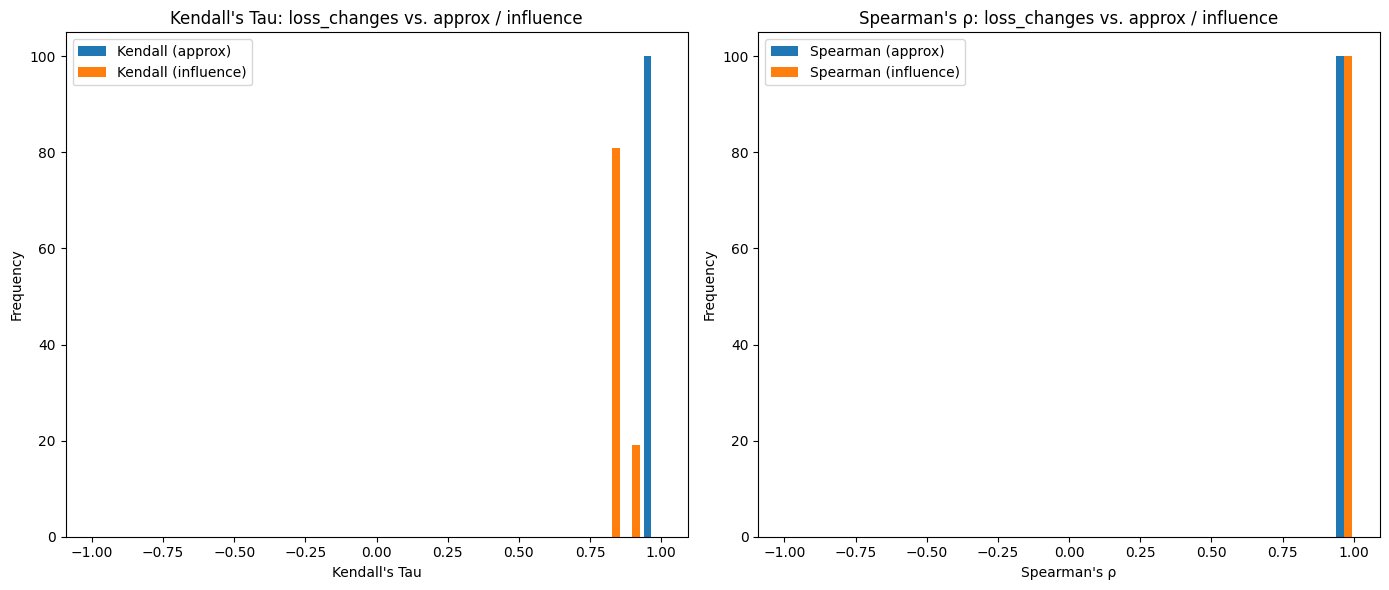

Kendall's Tau (approx):
  Min   = 0.9874
  Q1    = 0.9924
  Median= 0.9933
  Q3    = 0.9940
  Max   = 0.9954

Kendall's Tau (influence):
  Min   = 0.8398
  Q1    = 0.8529
  Median= 0.8575
  Q3    = 0.8609
  Max   = 0.8703

Spearman's Rho (approx):
  Min   = 0.9994
  Q1    = 0.9997
  Median= 0.9998
  Q3    = 0.9999
  Max   = 0.9999

Spearman's Rho (influence):
  Min   = 0.9648
  Q1    = 0.9704
  Median= 0.9725
  Q3    = 0.9737
  Max   = 0.9773



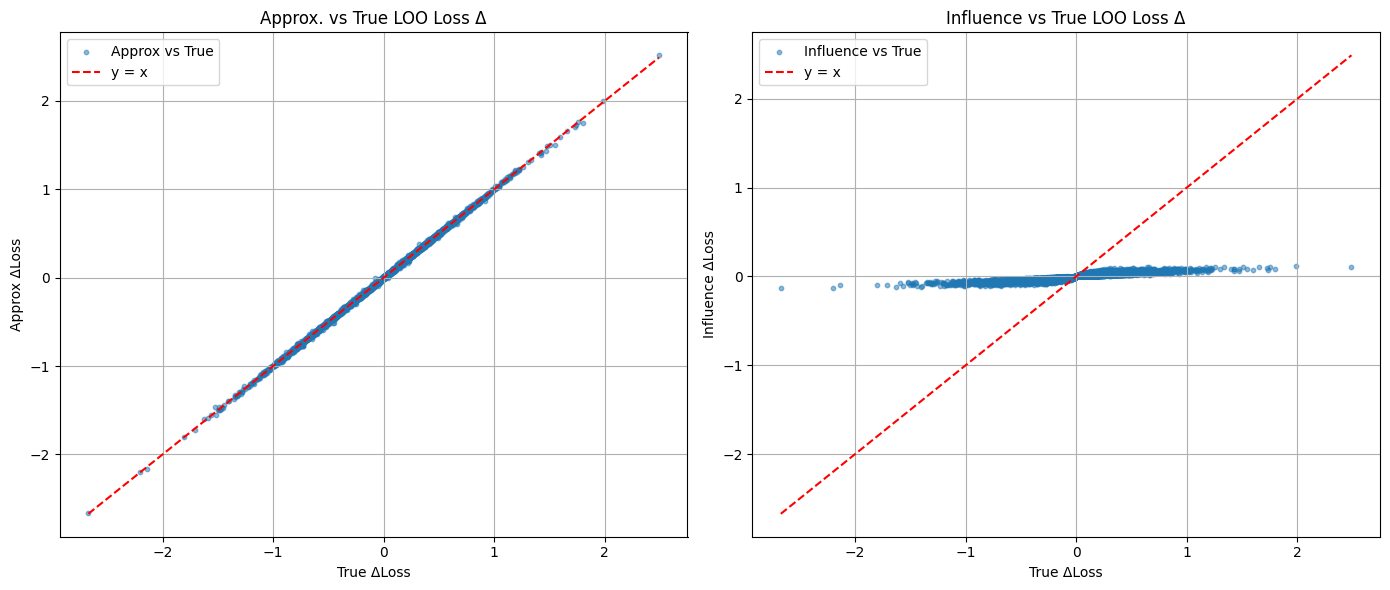

In [67]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt

# Prepare storage
kendall_tilde_values = []
kendall_infl_values = []
spearman_tilde_values = []
spearman_infl_values = []

n_train, m_test = loss_changes.shape

# Loop over each test point (column-wise)
for j in range(m_test):
    a = loss_changes[:, j]
    a_tilde = approx_loss_changes[:, j]
    a_infl = influence_values[:, j]

    # Compute correlations
    tau_tilde, _ = kendalltau(a, a_tilde)
    tau_infl, _ = kendalltau(a, a_infl)
    rho_tilde, _ = spearmanr(a, a_tilde)
    rho_infl, _ = spearmanr(a, a_infl)

    # Store them
    kendall_tilde_values.append(tau_tilde)
    kendall_infl_values.append(tau_infl)
    spearman_tilde_values.append(rho_tilde)
    spearman_infl_values.append(rho_infl)

# Convert lists to arrays
kendall_tilde_values = np.array(kendall_tilde_values)
kendall_infl_values = np.array(kendall_infl_values)
spearman_tilde_values = np.array(spearman_tilde_values)
spearman_infl_values = np.array(spearman_infl_values)

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
bins = np.linspace(-1, 1, 30)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.4

# Kendall's Tau
hist_k_tilde, _ = np.histogram(kendall_tilde_values, bins=bins)
hist_k_infl, _ = np.histogram(kendall_infl_values, bins=bins)
axes[0].bar(bin_centers - width/2, hist_k_tilde, width=width, label="Kendall (approx)")
axes[0].bar(bin_centers + width/2, hist_k_infl, width=width, label="Kendall (influence)")
axes[0].set_title("Kendall's Tau: loss_changes vs. approx / influence")
axes[0].set_xlabel("Kendall's Tau")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Spearman's Rho
hist_s_tilde, _ = np.histogram(spearman_tilde_values, bins=bins)
hist_s_infl, _ = np.histogram(spearman_infl_values, bins=bins)
axes[1].bar(bin_centers - width/2, hist_s_tilde, width=width, label="Spearman (approx)")
axes[1].bar(bin_centers + width/2, hist_s_infl, width=width, label="Spearman (influence)")
axes[1].set_title("Spearman's ρ: loss_changes vs. approx / influence")
axes[1].set_xlabel("Spearman's ρ")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

# 5-number summaries
def print_five_number_summary(name, data):
    q1, median, q3 = np.percentile(data, [25, 50, 75])
    print(f"{name}:")
    print(f"  Min   = {np.min(data):.4f}")
    print(f"  Q1    = {q1:.4f}")
    print(f"  Median= {median:.4f}")
    print(f"  Q3    = {q3:.4f}")
    print(f"  Max   = {np.max(data):.4f}\n")

print_five_number_summary("Kendall's Tau (approx)", kendall_tilde_values)
print_five_number_summary("Kendall's Tau (influence)", kendall_infl_values)
print_five_number_summary("Spearman's Rho (approx)", spearman_tilde_values)
print_five_number_summary("Spearman's Rho (influence)", spearman_infl_values)

# === Add Scatter Plots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Flatten everything
exact = loss_changes.flatten()
tilde = approx_loss_changes.flatten()
influence = influence_values.flatten()
line = np.linspace(np.min(exact), np.max(exact), 100)

# Scatter: Approx vs True
axes[0].scatter(exact, tilde, s=10, alpha=0.5, label="Approx vs True")
axes[0].plot(line, line, color='red', linestyle='--', label='y = x')
axes[0].grid(True)
axes[0].set_title("Approx. vs True LOO Loss Δ")
axes[0].set_xlabel("True ΔLoss")
axes[0].set_ylabel("Approx ΔLoss")
axes[0].legend()

# Scatter: Influence vs True
axes[1].scatter(exact, influence, s=10, alpha=0.5, label="Influence vs True")
axes[1].plot(line, line, color='red', linestyle='--', label='y = x')
axes[1].grid(True)
axes[1].set_title("Influence vs True LOO Loss Δ")
axes[1].set_xlabel("True ΔLoss")
axes[1].set_ylabel("Influence ΔLoss")
axes[1].legend()

plt.tight_layout()
plt.show()
